# Import required libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/kavan33_gmail_com/fastai/envv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from sklearn.metrics import f1_score, confusion_matrix

In [4]:
torch.cuda.set_device(0)

In [5]:
PATH = "/home/kavan33_gmail_com/fastai/data/"
sz = 224
arch = resnet50
bs = 32

In [6]:
label = pd.read_csv("/home/kavan33_gmail_com/fastai/data/TrainData/labels.csv")

In [7]:
label2 = label[:100000]

In [8]:
#label2.to_csv("/home/kavan33_gmail_com/fastai/data/TrainData/labels2.csv",index=False)

In [9]:
#l0 = label[label['label_id']==0][:55000]
#l1 = label[label['label_id']==1]
#l2 = label[label['label_id']==2]
#l3 = label[label['label_id']==3][:55000]
#label_truncated = pd.concat([l0,l1,l2,l3],axis=0)

In [10]:
#label_truncated.to_csv("/home/kavan33_gmail_com/fastai/data/TrainData/label.csv",index=False)

In [8]:
label_csv = "/home/kavan33_gmail_com/fastai/data/TrainData/labels2.csv" #CHANGE THIS ACCORDING TO NEED
n = len(list(open(label_csv))) - 1  
val_idxs = get_cv_idxs(n) 

In [9]:
label.head()

,image_id,label_id
0,396612,0
1,286612,3
2,421709,3
3,90089,0
4,296118,3


In [10]:
n

100000

In [11]:
len(val_idxs)

20000

# A visualization of distribution of classes

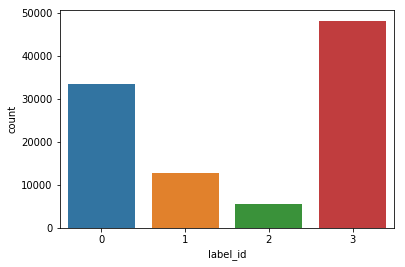

In [39]:
label_count = pd.DataFrame(label2.groupby(['label_id'])['label_id'].count())
label_count.columns = ['count']
label_count.reset_index(inplace=True)
sns.barplot(label_count['label_id'],label_count['count'])

#### Images of Class 2 are comparatively less than other classes, which might be a difficulty in learning the image.

In [12]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'TrainData', label_csv,val_idxs=val_idxs,test_name ='Test', suffix='.jpeg', tfms=tfms, bs=bs)

In [13]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'TrainData', label_csv, test_name ='Test',val_idxs=val_idxs, suffix='.jpeg', tfms=tfms, bs=bs)
    return data #if sz > 300 else data.resize(340, 'tmp')

In [14]:
data = get_data(sz, bs)

In [15]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [16]:
learn.fit(1e-2, 10) 

epoch      trn_loss   val_loss   accuracy                      
    0      0.532463   0.423053   0.84895   
    1      0.501088   0.405477   0.85265                       
    2      0.423538   0.378754   0.86305                       
    3      0.459125   0.371966   0.8679                        
    4      0.413089   0.363556   0.86905                       
    5      0.436928   0.363499   0.87145                       
    6      0.374294   0.359259   0.8708                        
    7      0.381241   0.349474   0.8741                        
    8      0.388396   0.347946   0.8748                        
    9      0.402566   0.338219   0.87955                       



[array([0.33822]), 0.87955]

## Making predictions 1

In [48]:
log_pred, y = learn.TTA()

In [49]:
probs = np.mean(np.exp(log_pred),0)

In [50]:
accuracy_np(probs,y)

0.86925

In [51]:
preds = np.argmax(probs,axis=1)

In [52]:
f1_score(y,preds,average='micro')

0.86925

In [53]:
cm = confusion_matrix(y,preds)

[[6447   66   13  256]
 [ 157 1878   49  516]
 [ 134  101  499  382]
 [ 600  219  122 8561]]


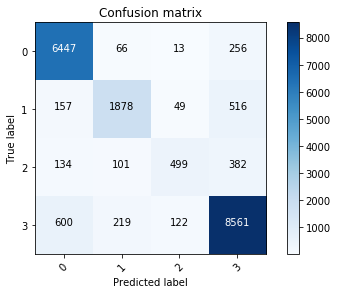

In [54]:
plot_confusion_matrix(cm, data.classes)

Looks like model is not able to learn Class 2 properly. i.e., Images of Class "Other"

 76%|███████▌  | 1892/2500 [27:38<07:19,  1.38it/s, loss=1.76]  

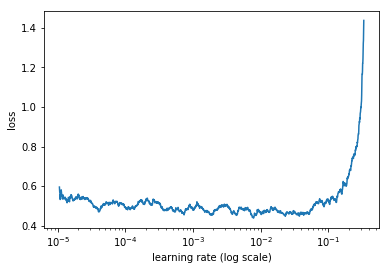

In [25]:
lrf = learn.lr_find()
learn.sched.plot()

In [46]:
learn.save("resnet_marco")

In [16]:
learn.load("resnet_marco")

## Making predictions 2

In [17]:
test_path = "/home/kavan33_gmail_com/TestData/Test/"

In [18]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)

In [19]:
test_info = pd.read_csv("/home/kavan33_gmail_com/TestData/Test/info.csv")

In [20]:
fn = data.test_ds.fnames

In [21]:
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)

In [22]:
dl = DataLoader(ds)

In [23]:
log_preds2, y2 = learn.TTA(is_test=True)

In [24]:
probs2 = np.mean(np.exp(log_preds2),0)

In [25]:
preds2 = np.argmax(probs2,axis=1)

In [65]:
preds2[:10]

array([2, 0, 3, 3, 1, 0, 3, 0, 3, 1])

In [87]:
preds2 = pd.DataFrame(preds2)
preds2.columns = ['predicted_label']
preds2.head()

,predicted_label
0,2
1,0
2,3
3,3
4,1


In [26]:
type(fn)

list

In [47]:
def test_performance(test_image_name_list,predictions):
    df = pd.Series( (v for v in test_image_name_list) )
    df2 = pd.DataFrame(df.astype(str).str[5:-5])
    df2.columns = ['image_id']
    df2['predicted_label'] = preds2
    df2['image_id'] = pd.to_numeric(df2['image_id'])
    result = pd.merge(df2,test_info[['image_id','label_id']],how = 'inner',on='image_id')
    acc = sum(result['predicted_label']==result['label_id'])/len(result)
    c2 = confusion_matrix(result['label_id'],result['predicted_label'])
    print ("Accuracy : ",acc)
    print ("Confusion Matrix:")
    return plot_confusion_matrix(c2,[0,1,2,3])

Accuracy :  0.8680785914774177
Confusion Matrix:
[[14951   142    41   524]
 [  390  4459   124  1227]
 [  295   257  1324   934]
 [ 1430   542   298 20090]]


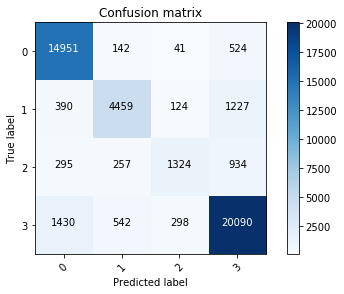

In [48]:
test_performance(fn,preds2)

#### Class 2 images are most incorrectly classified, So we need to find a way to improve upon these images rather than fine tuning the network

# UpSampling Class 2

In [51]:
label3 = pd.concat([label2,label2[label2['label_id']==2]])
label3 = pd.concat([label3,label2[label2['label_id']==2]])
label3.to_csv("/home/kavan33_gmail_com/fastai/data/TrainData/labels3.csv",index=False)

In [52]:
label_csv = "/home/kavan33_gmail_com/fastai/data/TrainData/labels3.csv" #CHANGE THIS ACCORDING TO NEED
n = len(list(open(label_csv))) - 1  
val_idxs = get_cv_idxs(n)

In [53]:
data2 = get_data(sz, bs)

In [55]:
learn2 = ConvLearner.pretrained(arch, data2, precompute=True)

100%|██████████| 695/695 [08:38<00:00,  1.40s/it]


In [56]:
learn2.fit(1e-2, 10)

epoch      trn_loss   val_loss   accuracy                      
    0      0.590195   0.485779   0.819916  
    1      0.520549   0.450548   0.834451                      
    2      0.501063   0.425125   0.84471                       
    3      0.496024   0.413036   0.849435                      
 23%|██▎       | 652/2778 [00:08<00:33, 63.14it/s, loss=0.447]

KeyboardInterrupt: 

# Improving the model 

In [17]:
learn.fit(0.1,3,cycle_len=1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.464003   0.371738   0.86635   
    1      0.393524   0.37015    0.8687                        
    2      0.425671   0.365699   0.86925                       



[array([0.3657]), 0.86925]

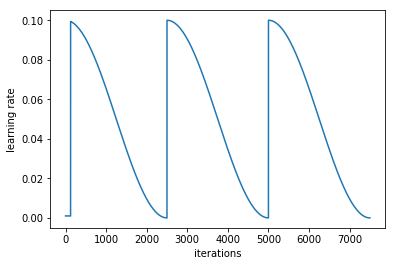

In [18]:
learn.sched.plot_lr()

In [19]:
learn.save("resnet_marco")

In [20]:
learn.load("resnet_marco")

## Fine Tunning the model

In [21]:
learn.unfreeze()

In [22]:
lr = np.array([1e-3,1e-2,1e-1])

In [26]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                       
    0      0.454515   0.376928   0.86675   
 80%|███████▉  | 1988/2500 [28:40<08:19,  1.02it/s, loss=0.506]  

KeyboardInterrupt: 